## Mathematics of Machine Learning

## Chapter 3: Linear classification methods

### Section 3.3: Hard SVM Rule

In [14]:
import numpy as np
import scipy.optimize as opt 
import matplotlib.pyplot as plt

# change font size for all matplotlib plots
plt.rc('font', size=16)

#### (0) Data Preparation

(a) Generate the training data

In [15]:
# Size of the dataset
m = 25

# Uniform sampling of features in [-3,3]^2
rng = np.random.default_rng(seed=17)
x = rng.uniform(low=-3, high=3, size=(2, m))

In [16]:
# true parameters of separating hyperplane
w_true = np.array([1, 2])

# True labels
y = np.sign(w_true @ x) + ((w_true @ x) == 0)

# Margin distance of the true hypothesis
gamma_true = 1/np.linalg.norm(w_true) * np.min(np.abs(w_true @ x))
print(gamma_true)

0.199888204652525


(b) Plotting the data

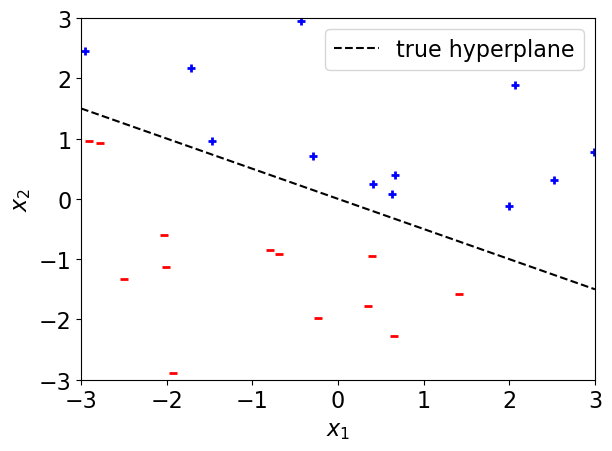

In [17]:
fig, ax = plt.subplots()
xvec = np.array([-3,3])
yvec = -w_true[0]/w_true[1]*xvec

# First plot the true hyperplane for x in [-3,3]
ax.plot(xvec, yvec, "--k", label="true hyperplane")

# Then enter the classified points
inds = np.where(y==1)[0]
indm = np.where(y==-1)[0]

ax.scatter(x[0][inds], x[1][inds], c="b", marker="+", linewidths = 2)
ax.scatter(x[0][indm], x[1][indm], c="r", marker="_", linewidths = 2)
plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
ax.grid(linestyle='dotted')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
fig.tight_layout()

#### (1) Apply hard SVM Rule

In [18]:
# Define objective function to minimize for hard SVM
fun = lambda w: np.linalg.norm(w,2)**2

# Define the linear inequality constraints of the hard SVM
A = x * y  # (1,m) * (2,m) results in elementwise multiplication (broadcast x as single row to each rows in y)
lc = opt.LinearConstraint(-A.T, ub=-np.ones(m))

# Initial state
x0 = [0,0]

# Compute hard SVM rule
SVM = opt.minimize(fun, x0, constraints=lc, options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.523624680486527
            Iterations: 3
            Function evaluations: 10
            Gradient evaluations: 3


In [21]:
# Output found weight vector and its norm
w = SVM.x
norm_w = SVM.fun
print(w)

# Maximum margin
gamma = 1/np.sqrt(norm_w)
print(gamma)

[1.43088017 3.23669687]
0.28257580799866044


We plot the admissible range and the objective function.

In [22]:
# To do this, we determine the columns of A with A[1, :] negative or positive ...
indAn = np.where(A[1, :]<0)[0]
indAp = np.where(A[1, :]>0)[0]

# ... and build from it the lower and upper bound of the admissible range.
def a_low(w1):
    tmp = (1 - np.atleast_2d(w1).T * A[0, indAp])
    return np.max(tmp/A[1, indAp],  # applies '/' of row 'A[1,indAp]' to each row of matrix 'tmp'
                  axis = 1)  # max over columns # (nrows, ncols) -> (nrows)
    
def a_up(w1):
    tmp = (1 - np.atleast_2d(w1).T * A[0, indAn])
    return np.min(tmp/A[1, indAn], axis = 1)

# We discretize w1 in the corresponding range.
w1 = np.arange(0, 1/gamma, 0.01)

# And determine the bounds for w2.
w2_low = a_low(w1)
w2_up = a_up(w1)

# We are looking for the "intersection" of the lower and upper boundary.
isect = np.where(w2_low <= w2_up)[0]
ind = np.min(isect)

In [28]:
# To plot the height lines of the objective function
# we generate discretization of the w-values per axis
w1s = np.arange(0, np.max(w1) + np.max(w1)/500, np.max(w1)/500)
w2s = np.arange(0, np.max(w2_up) + np.max(w2_up)/500, np.max(w2_up)/500)

# Generate discretization grid
WW1, WW2 = np.meshgrid(w1s, w2s)

# Evaluate objective function on the grid points
F_Ws = (np.ravel(WW1)**2 + np.ravel(WW2)**2)

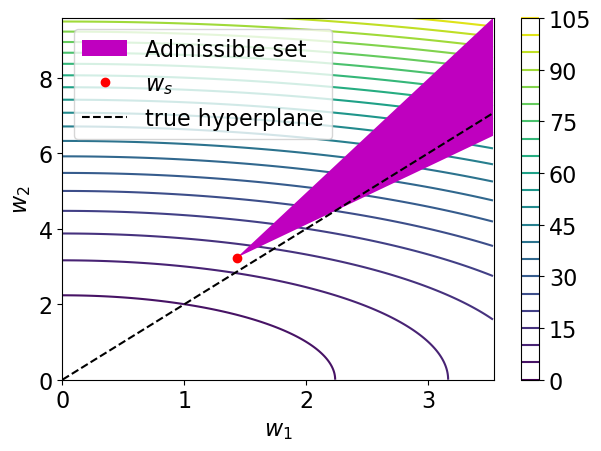

In [31]:
# Generate graphic (contour plot)
fig, ax = plt.subplots()

CS = ax.contour(WW1, WW2, np.reshape(F_Ws, (len(w1s), len(w2s))), 25, zorder=1)
fig.colorbar(CS)

# Plot the permissible set
ax.fill(np.concatenate((w1[ind:], w1[:(ind-1):-1])), 
        np.concatenate((w2_low[ind:], w2_up[:(ind-1):-1])),
        'm', 
        label='Admissible set', 
        zorder=2)

# Plot the solution of the hard SVM rule and the true parameter
ax.plot(w[0], w[1], 'or', label='$w_s$')
ax.plot(w1, w_true[1]/w_true[0]*w1, '--k', label='true hyperplane')

ax.legend()
plt.xlim([0, 1/gamma])
plt.ylim([0, max(w2_up)])
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.tight_layout()
plt.show()

#### (2) Plot learned hypothesis and training data

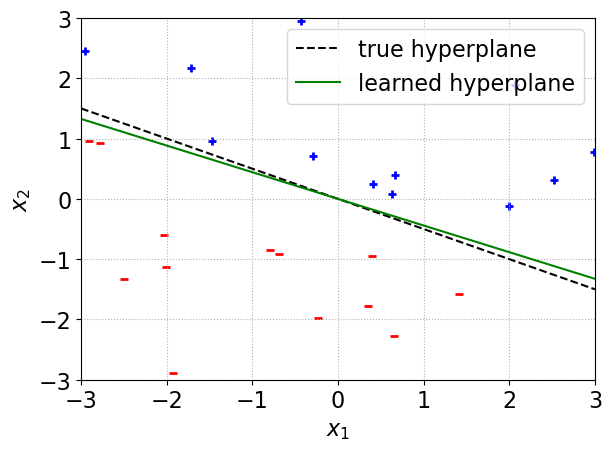

In [34]:
fig, ax = plt.subplots()

xvec = np.array([-3,3])
yvec = -w_true[0]/w_true[1]*xvec

# First plot the true hyperplane for x in [-3,3]
ax.plot(xvec, yvec, "--k", label="true hyperplane")

# Plot the learned hypothesis
ax.plot(xvec, -w[0]/w[1]*xvec, "-", c="g", label="learned hyperplane")

# Then enter the classified points
inds = np.where(y==1)[0]
indm = np.where(y==-1)[0]

ax.scatter(x[0][inds], x[1][inds], c="b", marker="+", linewidths = 2)
ax.scatter(x[0][indm], x[1][indm], c="r", marker="_", linewidths = 2)

plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
ax.grid(linestyle='dotted')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
fig.tight_layout()

#### (3) Identify and display the support vectors

In [82]:
# Find those points where contraint is statisfied with equality:
supp_ind = np.where( np.abs(y * (w @ x) - 1) <= 1e-12)
x_supp = x[:,supp_ind[0]]
x_supp

# Compute coefficients of linear combination of w:
alpha = np.linalg.solve(x_supp,w)
x_supp @ alpha

array([4.4408921e-16, 4.4408921e-16])

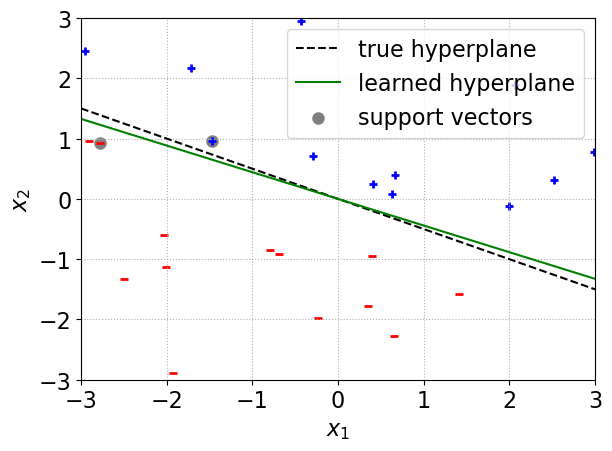

In [88]:
fig, ax = plt.subplots()

xvec = np.array([-3,3])
yvec = -w_true[0]/w_true[1]*xvec

# First plot the true hyperplane for x in [-3,3]
ax.plot(xvec, yvec, "--k", label="true hyperplane")

# Plot the learned hypothesis
ax.plot(xvec, -w[0]/w[1]*xvec, "-", c="g", label="learned hyperplane")

# Then enter the classified points
inds = np.where(y==1)[0]
indm = np.where(y==-1)[0]

ax.scatter(x[0][supp_ind[0]], x[1][supp_ind[0]], c="grey", marker="o", linewidths = 3, label="support vectors")

ax.scatter(x[0][inds], x[1][inds], c="b", marker="+", linewidths = 2)
ax.scatter(x[0][indm], x[1][indm], c="r", marker="_", linewidths = 2)


plt.legend()
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
ax.grid(linestyle='dotted')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
fig.tight_layout()